In [31]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import pickle
import pandas as pd

pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

In [32]:
def get_pickles(): 
    x_train = pickle.load(open(f'../../data/processed/pickles/basin_x_train.p', 'rb'))
    x_test = pickle.load(open(f'../../data/processed/pickles/basin_x_test.p', 'rb'))
    y_train = pickle.load(open(f'../../data/processed/pickles/basin_y_train.p', 'rb'))
    y_test = pickle.load(open(f'../../data/processed/pickles/basin_y_test.p', 'rb'))
    X = pickle.load(open('../../data/processed/pickles/basin_X.p', 'rb'))
    y = pickle.load(open('../../data/processed/pickles/basin_y.p', 'rb'))

    return (x_train, x_test, y_train, y_test), (X,y)

(x_train, x_test, y_train, y_test), (X,y) = get_pickles()

unique_basin = X.basin.unique() 
print(f'Original X: {X.shape}\tOriginal y: {y.shape}')
print(f'Train X: {x_train.shape}\tTrain y: {y_train.shape}')
print(f'Test X: {x_test.shape}\tTest y: {y_test.shape}')

y_train = y_train.target.values.ravel()
y_test = y_test.target.values.ravel()
y = y.target.values.ravel()

standard = StandardScaler() 
x_train[['amount_tsh', 'gps_height', 
         'population', 'time_passed']] = standard.fit_transform(x_train[['amount_tsh', 
                                                                         'gps_height', 'population', 'time_passed']])

Original X: (57247, 45)	Original y: (57247, 1)
Train X: (42935, 45)	Train y: (42935, 1)
Test X: (14312, 45)	Test y: (14312, 1)


In [16]:
X['target'] = y
x_test['target'] = y_test
x_train['target'] = y_train

In [70]:
import os 
from mlxtend.classifier import StackingCVClassifier


scores = []
basins = []
basin_model_dict= {} 
pbar = os.listdir('../../data/processed/pickles/basins/')
for i in os.listdir('../../data/processed/pickles/basins/'):
    if i == '.DS_Store': 
        continue 
    basins.append(i)
    #pbar.set_description(f'Testing Classifier for: {i.upper()}')
    x_train = pickle.load(open(f'../../data/processed/pickles/basins/{i}/x_train.p', 'rb'))
    x_test = pickle.load(open(f'../../data/processed/pickles/basins/{i}/x_test.p', 'rb'))
    y_train = pickle.load(open(f'../../data/processed/pickles/basins/{i}/y_train.p', 'rb'))
    y_test = pickle.load(open(f'../../data/processed/pickles/basins/{i}/y_test.p', 'rb'))
    
    x_train.drop('basin', axis =1, inplace = True)
    x_test.drop('basin', axis =1, inplace = True)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()   
    
   
    standard = StandardScaler()
    x_train[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']] = standard.fit_transform(
                                 x_train[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']]
    )
    x_test[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']] = standard.fit_transform(
        x_test[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']]
    )
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3)
    classifiers = [DecisionTreeClassifier(), RandomForestClassifier()]
    sclf = StackingCVClassifier(classifiers = classifiers, meta_classifier = LogisticRegression(), random_state = 10)

    params = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': [None, 125, 500, 1000],
    'decisiontreeclassifier__min_samples_split': [8, 10, 15],
    'decisiontreeclassifier__min_samples_leaf': [3, 5, 10], 
    'decisiontreeclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'decisiontreeclassifier__max_leaf_nodes': [None, 25,  50],
    
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [None, 50, 100, 150, 200],
    'randomforestclassifier__min_samples_split': [8,10, 15],
    'randomforestclassifier__min_samples_leaf': [3, 5, 10],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_leaf_nodes': [None, 25, 50], 
    'randomforestclassifier__bootstrap': [False, True],
      
    'meta_classifier__C': [.1, .5, 1, 1.25, 1.5, 2], 
    'meta_classifier__max_iter': [100, 1000,2000],
    'meta_classifier__penalty': ['l1', 'l2'],
    'meta_classifier__solver': ['sag', 'saga', 'liblinear', 'lbfgs', 'newton-cg'],
    'meta_classifier__multi_class': ['ovr', 'multinomial']    
}
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3)
    gs = RandomizedSearchCV(estimator = sclf, param_distributions = params, cv = cv, n_jobs = 13, verbose = 1, n_iter = 13)
    gs.fit(x_train,y_train)
    pickle.dump(gs, open(f'../../models/Basins/{i}_GridSearch.p', 'wb'))
    basin_dict = dict(model = gs, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test) 
    basin_model_dict[i] = basin_dict
    

    

In [36]:
import os 

scores = []
basins = []
basin_model_dict= {} 
pbar = os.listdir('../../data/processed/pickles/basins/')
for i in os.listdir('../../data/processed/pickles/basins/'):
    if i == '.DS_Store': 
        continue 
    basins.append(i)
    #pbar.set_description(f'Testing Classifier for: {i.upper()}')
    x_train = pickle.load(open(f'../../data/processed/pickles/basins/{i}/x_train.p', 'rb'))
    x_test = pickle.load(open(f'../../data/processed/pickles/basins/{i}/x_test.p', 'rb'))
    y_train = pickle.load(open(f'../../data/processed/pickles/basins/{i}/y_train.p', 'rb'))
    y_test = pickle.load(open(f'../../data/processed/pickles/basins/{i}/y_test.p', 'rb'))
    
    x_train.drop('basin', axis =1, inplace = True)
    x_test.drop('basin', axis =1, inplace = True)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    rf = RandomForestClassifier()
   
    
#     plot_confusion_matrix(rf, x_test, y_test)
    param_grid = {
     'criterion': ['gini', 'entropy'],
    'max_depth': [100, 250, 300, 350, 450],
    'min_samples_split': [5, 8,10, 15],
    'min_samples_leaf': [3, 5, 10, 15],
    'max_features': ['sqrt', 'log2'],
}
    standard = StandardScaler()
    x_train[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']] = standard.fit_transform(
                                 x_train[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']]
    )
    x_test[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']] = standard.fit_transform(
        x_test[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']]
    )
    cv = RepeatedStratifiedKFold(n_splits = 7, n_repeats = 5)
    gs = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = cv, n_jobs = 13, verbose = 2, 
                            n_iter = 75)

    gs.fit(x_train, y_train)
    pickle.dump(gs, open(f'../../models/Basins/{i}_GridSearch.p', 'wb'))
    basin_dict = dict(model = gs, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test) 
    basin_model_dict[i] = basin_dict
    

pickle.dump(basin_model_dict, open(f'../../models/Basins/TunedModels.p', 'wb'))
    

Fitting 35 folds for each of 75 candidates, totalling 2625 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    3.0s
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:   10.4s
[Parallel(n_jobs=13)]: Done 339 tasks      | elapsed:   21.5s
[Parallel(n_jobs=13)]: Done 622 tasks      | elapsed:   37.4s
[Parallel(n_jobs=13)]: Done 987 tasks      | elapsed:   57.0s
[Parallel(n_jobs=13)]: Done 1432 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 1959 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 2566 tasks      | elapsed:  2.5min
[Parallel(n_jobs=13)]: Done 2625 out of 2625 | elapsed:  2.5min finished


Fitting 35 folds for each of 75 candidates, totalling 2625 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    0.8s
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:    5.2s
[Parallel(n_jobs=13)]: Done 339 tasks      | elapsed:   12.8s
[Parallel(n_jobs=13)]: Done 622 tasks      | elapsed:   23.7s
[Parallel(n_jobs=13)]: Done 987 tasks      | elapsed:   37.1s
[Parallel(n_jobs=13)]: Done 1432 tasks      | elapsed:   53.1s
[Parallel(n_jobs=13)]: Done 1959 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 2566 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 2625 out of 2625 | elapsed:  1.6min finished


Fitting 35 folds for each of 75 candidates, totalling 2625 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    2.1s
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:    9.2s
[Parallel(n_jobs=13)]: Done 339 tasks      | elapsed:   22.1s
[Parallel(n_jobs=13)]: Done 622 tasks      | elapsed:   41.1s
[Parallel(n_jobs=13)]: Done 987 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 1432 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 1959 tasks      | elapsed:  2.1min
[Parallel(n_jobs=13)]: Done 2566 tasks      | elapsed:  2.8min
[Parallel(n_jobs=13)]: Done 2625 out of 2625 | elapsed:  2.9min finished


Fitting 35 folds for each of 75 candidates, totalling 2625 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    1.8s
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:    8.8s
[Parallel(n_jobs=13)]: Done 339 tasks      | elapsed:   22.4s
[Parallel(n_jobs=13)]: Done 622 tasks      | elapsed:   40.1s
[Parallel(n_jobs=13)]: Done 987 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 1432 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 1959 tasks      | elapsed:  2.1min
[Parallel(n_jobs=13)]: Done 2566 tasks      | elapsed:  2.7min
[Parallel(n_jobs=13)]: Done 2625 out of 2625 | elapsed:  2.7min finished


Fitting 35 folds for each of 75 candidates, totalling 2625 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    0.7s
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:    3.6s
[Parallel(n_jobs=13)]: Done 339 tasks      | elapsed:    8.7s
[Parallel(n_jobs=13)]: Done 622 tasks      | elapsed:   15.9s
[Parallel(n_jobs=13)]: Done 987 tasks      | elapsed:   24.7s
[Parallel(n_jobs=13)]: Done 1432 tasks      | elapsed:   36.2s
[Parallel(n_jobs=13)]: Done 1959 tasks      | elapsed:   49.9s
[Parallel(n_jobs=13)]: Done 2566 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 2625 out of 2625 | elapsed:  1.1min finished


Fitting 35 folds for each of 75 candidates, totalling 2625 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:    5.4s
[Parallel(n_jobs=13)]: Done 339 tasks      | elapsed:   12.9s
[Parallel(n_jobs=13)]: Done 622 tasks      | elapsed:   23.3s
[Parallel(n_jobs=13)]: Done 987 tasks      | elapsed:   37.6s
[Parallel(n_jobs=13)]: Done 1432 tasks      | elapsed:   54.0s
[Parallel(n_jobs=13)]: Done 1959 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 2566 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 2625 out of 2625 | elapsed:  1.7min finished


Fitting 35 folds for each of 75 candidates, totalling 2625 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:    6.0s
[Parallel(n_jobs=13)]: Done 339 tasks      | elapsed:   14.9s
[Parallel(n_jobs=13)]: Done 622 tasks      | elapsed:   26.9s
[Parallel(n_jobs=13)]: Done 987 tasks      | elapsed:   42.2s
[Parallel(n_jobs=13)]: Done 1432 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 1959 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 2566 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 2625 out of 2625 | elapsed:  1.9min finished


Fitting 35 folds for each of 75 candidates, totalling 2625 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    1.1s
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:    8.1s
[Parallel(n_jobs=13)]: Done 339 tasks      | elapsed:   20.1s
[Parallel(n_jobs=13)]: Done 622 tasks      | elapsed:   37.7s
[Parallel(n_jobs=13)]: Done 987 tasks      | elapsed:   58.9s
[Parallel(n_jobs=13)]: Done 1432 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 1959 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 2566 tasks      | elapsed:  2.5min
[Parallel(n_jobs=13)]: Done 2625 out of 2625 | elapsed:  2.6min finished


Fitting 35 folds for each of 75 candidates, totalling 2625 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    0.8s
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:    5.1s
[Parallel(n_jobs=13)]: Done 339 tasks      | elapsed:   13.5s
[Parallel(n_jobs=13)]: Done 622 tasks      | elapsed:   25.8s
[Parallel(n_jobs=13)]: Done 987 tasks      | elapsed:   41.6s
[Parallel(n_jobs=13)]: Done 1432 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 1959 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 2566 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 2625 out of 2625 | elapsed:  1.8min finished


In [37]:
# fig, ax = plt.subplots(1, len(basin_model_dict.keys()))
for idx, i in enumerate(basin_model_dict.keys()): 
    print(i)
    basin_dict = basin_model_dict[i]
    model = basin_dict['model']
    print(model.best_estimator_)

int
RandomForestClassifier(criterion='entropy', max_depth=350, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=8)
nya
RandomForestClassifier(max_depth=300, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5)
pang
RandomForestClassifier(criterion='entropy', max_depth=250, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=8)
ruf
RandomForestClassifier(criterion='entropy', max_depth=350, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5)
rukwa
RandomForestClassifier(criterion='entropy', max_depth=250, max_features='log2',
                       min_samples_leaf=3, min_samples_split=5)
ruv
RandomForestClassifier(criterion='entropy', max_depth=250, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=8)
tang
RandomForestClassifier(criterion='entropy', max_depth=100, max_features='sqrt',
                       min_samples_leaf=3, mi

In [51]:
orig_dict = {'Lake Nyasa' : 'nya', 'Lake Victoria' : 'vic', 'Pangani' : 'pang', 'Ruvuma / Southern Coast' : 'ruv', \
                 'Internal' : 'int', 'Lake Tanganyika' : 'tang', 'Wami / Ruvu' : 'wami', 'Rufiji' : 'ruf',
             'Lake Rukwa' : 'rukwa'}


new_dict = {y:i for i,y in orig_dict.items()}
# new_dict

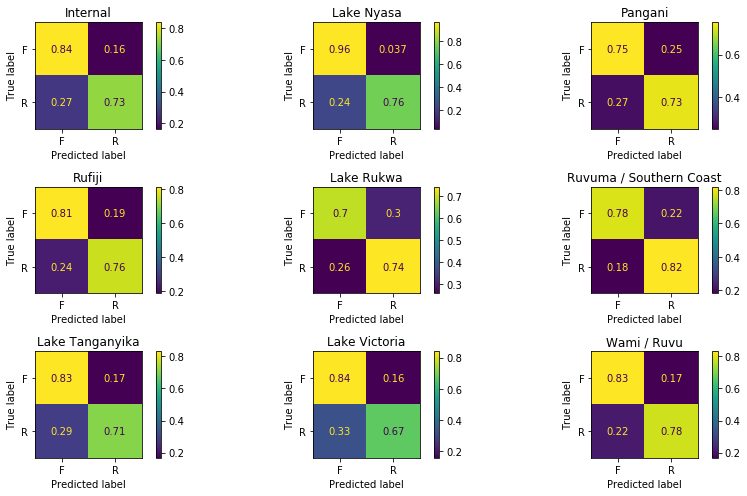

In [52]:
fig, ax = plt.subplots(3, 3, figsize = (12,7))
cm_dict = {}
for idx, i in enumerate(basin_model_dict.keys()): 
    basin_dict = basin_model_dict[i]
    model =basin_dict['model'].best_estimator_
    x_test = basin_dict['x_test']
    y_test = basin_dict['y_test']
    plot_confusion_matrix(model, x_test, y_test, 
                          display_labels = ['F', 'R'], ax = ax[idx//3, idx%3], normalize = 'true')
    ax[idx//3, idx%3].set_title(f'{new_dict[i]}')
    cm_dict[i] = confusion_matrix(y_test, model.predict(x_test))
    
plt.tight_layout()
plt.savefig(f'figures/BASINS_confusion_matrix.png')

In [59]:
pickle.dump(cm_dict, open(f'../../models/Basins/BasinCMDict.p', 'wb'))


In [40]:
basin_model_dict = pickle.load(open(f'../../models/Basins/TunedModels.p', 'rb'))
pbar = tqdm(basin_model_dict.keys())
final_results = {} 
for bas in pbar: 
    pbar.set_description(f'KFold: {bas}')
    model = basin_model_dict[bas]['model'].best_estimator_
    x_train = basin_model_dict[bas]['x_train']
    x_test = basin_model_dict[bas]['x_test']
    X = x_train.append(x_test, ignore_index = True)
    
    y_train = pd.DataFrame(basin_model_dict[bas]['y_train'], columns = ['target'])
    y_test = pd.DataFrame(basin_model_dict[bas]['y_test'], columns = ['target'])
    y = y_train.append(y_test, ignore_index = True)
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)
    scores = cross_val_score(model, X, y.target.values, scoring = 'accuracy', cv = cv, n_jobs = 12, 
                             error_score = 'raise')
    final_results[bas]=  scores
    


KFold: wami: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:20<00:00,  8.99s/it]


In [41]:
final_results

{'int': array([0.85900474, 0.8436019 , 0.85663507, 0.82819905, 0.8507109 ,
        0.8471564 , 0.8542654 , 0.83886256, 0.85189573, 0.86018957,
        0.84952607, 0.84834123, 0.84952607, 0.85900474, 0.83293839,
        0.83530806, 0.8471564 , 0.85900474, 0.85545024, 0.84597156,
        0.83886256, 0.86137441, 0.86374408, 0.85545024, 0.8542654 ,
        0.84241706, 0.84834123, 0.84597156, 0.8436019 , 0.85663507,
        0.86018957, 0.8542654 , 0.8507109 , 0.85308057, 0.86137441,
        0.84241706, 0.8507109 , 0.84478673, 0.86018957, 0.82345972,
        0.83412322, 0.85900474, 0.8507109 , 0.83767773, 0.86018957,
        0.82109005, 0.86255924, 0.83886256, 0.85781991, 0.85781991,
        0.85308057, 0.83530806, 0.85545024, 0.86729858, 0.85900474,
        0.85308057, 0.8542654 , 0.84597156, 0.84834123, 0.84952607,
        0.83767773, 0.84952607, 0.8436019 , 0.87322275, 0.8471564 ,
        0.85189573, 0.85781991, 0.85545024, 0.85308057, 0.86374408,
        0.85189573, 0.83886256, 0.8447867

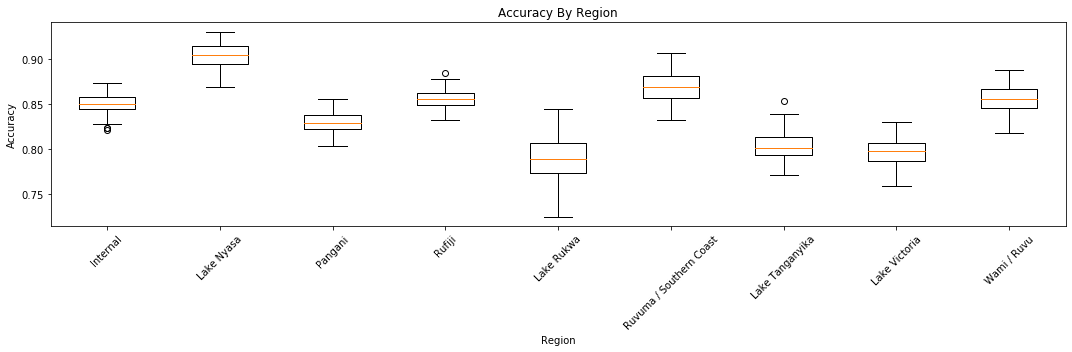

In [57]:
plt.figure(figsize = (15,5))
names = [new_dict[i] for i in final_results.keys()]
results = [i[1] for i in final_results.items()]
plt.boxplot(results, labels = names)
plt.title('Accuracy By Region')
plt.xlabel('Region')
plt.ylabel('Accuracy')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('figures/ByRegionKFold.png')
plt.show()